In [28]:
#%matplotlib notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\apbarret\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap

import os

import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [30]:
ediri = r'C:\Users\apbarret\Documents\data\Arctic_precip'
efile = r'NPP-yang_copy_apb.xls'
df = pd.read_excel(os.path.join(ediri, efile), sheet_name='monthly-all', header=0, skiprows=[1,2,3], 
                   na_values='-', usecols=14)
df = df.dropna(how='all')
df.head()

,NP,YY,MM,ND,Lat,Lon,Tmn,Ug,DP,Dtc,snow%,Pg,windC,traceC,Pc
0,31.0,89.0,1.0,31.0,74.51,-150.67,-31.2,4.7,5.0,25.0,100.0,2.0,1.5,2.5,6.0
1,31.0,89.0,2.0,28.0,74.70,-147.57,-20.3,4.7,19.0,8.0,100.0,21.3,20.3,0.8,42.4
2,31.0,89.0,3.0,31.0,75.30,-146.08,-28.8,3.9,6.0,24.0,100.0,4.3,4.3,2.4,11.0
3,31.0,89.0,4.0,30.0,75.48,-146.26,-22.2,3.6,9.0,20.0,100.0,5.1,2.6,2.0,9.7
4,31.0,89.0,5.0,31.0,75.46,-146.25,-11.2,3.2,18.0,12.0,100.0,7.4,2.9,1.2,11.5


Get Arctic Ocean mask

In [31]:
def landmask(region):
    
    import xarray as xr
    import os

    mdiri = r"C:\Users\apbarret\Documents\data\ancillary"
    mfili = r"arctic_mask_1x1deg.nc"
    ds = xr.open_dataset(os.path.join(mdiri,mfili))
    
    if (region == 'arctic_ocean'):
        return ds['arctic_mask'].where(ds['arctic_mask'] >= 6)*0.+ 1 #Includes small Arctic islands
    elif (region == 'antarctic_ocean'):
        return ds['arctic_mask'].where((ds['arctic_mask'] == 0) & (ds['lat'] <= -50))*0. + 1
    else:
        print ("landmask: Unknown region")
        return None

Get locations for sattellite period

In [32]:
df_satt = df[df['YY'] >= 79]
df_satt.head()

,NP,YY,MM,ND,Lat,Lon,Tmn,Ug,DP,Dtc,snow%,Pg,windC,traceC,Pc
0,31.0,89.0,1.0,31.0,74.51,-150.67,-31.2,4.7,5.0,25.0,100.0,2.0,1.5,2.5,6.0
1,31.0,89.0,2.0,28.0,74.70,-147.57,-20.3,4.7,19.0,8.0,100.0,21.3,20.3,0.8,42.4
2,31.0,89.0,3.0,31.0,75.30,-146.08,-28.8,3.9,6.0,24.0,100.0,4.3,4.3,2.4,11.0
3,31.0,89.0,4.0,30.0,75.48,-146.26,-22.2,3.6,9.0,20.0,100.0,5.1,2.6,2.0,9.7
4,31.0,89.0,5.0,31.0,75.46,-146.25,-11.2,3.2,18.0,12.0,100.0,7.4,2.9,1.2,11.5


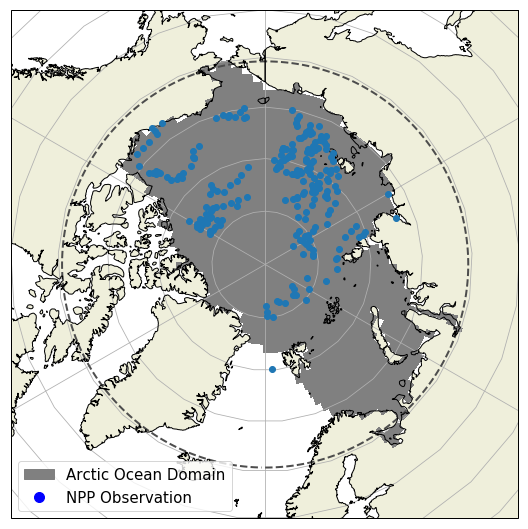

In [43]:
fig = plt.figure(figsize=(20,20))

# get mask
mask = landmask('arctic_ocean')
mask_proj = ccrs.PlateCarree()
mask_extent = (-180, 180, -90, 90)

map_proj = ccrs.Orthographic(0, 90)

# Set colormap
colors = [(0,0,0),(0.5,0.5,0.5)]
cm = LinearSegmentedColormap.from_list('cm_binary', colors, N=len(colors))


# Define Arctic circle
arcrcl_lat = np.ones(360)*66.5
arcrcl_lon = np.arange(0.,360.,1.)


land_fill = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor=None,
                                        facecolor=cfeature.COLORS['land'])
land_edge = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor='none')

ax1 = plt.subplot(1, 2, 1, projection=map_proj)
ax1.set_extent([-180,180.,60.,90.], ccrs.PlateCarree())
#ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(land_fill)
ax1.add_feature(land_edge, zorder=3)

ax1.gridlines()

arctic_mask.plot(ax=ax1, vmin=0., vmax=1., add_colorbar=False, 
                 cmap=cm, transform=mask_proj, zorder=2)
#ax1.imshow(arctic_mask, vmin=0., vmax=1., origin='upper',
#           cmap=cm, transform=mask_proj, extent=mask_extent, zorder=2)

ax1.plot(arcrcl_lon, arcrcl_lat, transform=ccrs.Geodetic(), linestyle='--', lw=2., color='0.3')

xy = map_proj.transform_points(ccrs.PlateCarree(), df_satt['Lon'].values, df_satt['Lat'].values)

ax1.scatter(xy[:,0], xy[:,1], zorder=4, label='NPP observation')

patch = mpatches.Patch(color=colors[1], label='Arctic Ocean Domain')
circle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                       markersize=10, label='NPP Observation')
ax1.legend(handles=[patch, circle], loc=3, fontsize=15)


fig.savefig(os.path.join(r"C:\Users\apbarret\Documents\Papers\Snow_on_seaice_precip\Figures",'arctic_ocean_domain.png'),
            bbox_inches='tight')

In [47]:
(6*139)+391+704

1929